# **GPyTorch Multifidelity Deep Gaussian Processes Tutorial**

This notebook illustrates the use of deep Gaussian processes for modeling Multifidelity data using GPyTorch. We will consider the implementation described by Salimbeni, using doubly stochastic variational inference (https://arxiv.org/abs/1705.08933). The multifidelity architecture is described in the paper https://arxiv.org/abs/1903.07320, where the output of low fidelities is used as an input for high fidelities.

Again, Deep GPs are only partially implemented in GPytorch, and we will have to do many high level things on our own, such as creating the model, propagating samples across layers, etc.

In [188]:
!pip install gpytorch==1.13

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip


For simplicity, we avoid using GPU acceleration and do the necessary imports.


In [189]:
%set_env CUDA_VISIBLE_DEVICES=0

import math
import torch
import gpytorch
import numpy as np
from torch.nn import Parameter
from matplotlib import pyplot as plt

from gpytorch.means import ConstantMean, LinearMean, ZeroMean
from gpytorch.kernels import RBFKernel, LinearKernel, ScaleKernel
from typing import Optional
from gpytorch.priors import Prior
from gpytorch.constraints import Interval
from gpytorch.models import ApproximateGP

from gpytorch.variational import VariationalStrategy, CholeskyVariationalDistribution, UnwhitenedVariationalStrategy
from gpytorch.distributions import MultivariateNormal
from gpytorch.models.deep_gps import DeepGPLayer, DeepGP
from gpytorch.lazy import LazyEvaluatedKernelTensor
from gpytorch.mlls import VariationalELBO
from gpytorch.likelihoods import GaussianLikelihood

torch.manual_seed(0)

env: CUDA_VISIBLE_DEVICES=0


## **Generating the Training Data**

For simplicity, we will consider a simple dataset with two fidelities. We will have more observations of the lower fidelity and fewer of the higher fidelity. The dataset is described in https://arxiv.org/pdf/1903.07320

In [190]:
# We consider data in the interval [0,1]

x_low = torch.linspace(0, 1, 100)[:,None]
x_high = torch.linspace(0, 1, 100)[:,None]

y_low = torch.sin(8 * 3.1415926 * x_low)
y_high = (x_high - np.sqrt(2.0)) * torch.sin(8 * 3.1415926 * x_high)**2

#y_low = torch.cos(15 * x_low)
#y_high = x_high * torch.exp(torch.cos(15 * (2.0 * x_high - 0.2))) - 1

# We choose 50 points for the lower fidelity and 14 points for
# the higher fidelity

s_low = np.arange(0, 100, 2)
s_high= np.arange(15, 80, 5)

x_train_low = x_low[ s_low, : ]
y_train_low = y_low[ s_low, : ]
x_train_high = x_high[ s_high]
y_train_high = y_high[ s_high]


We plot the data for visualization.

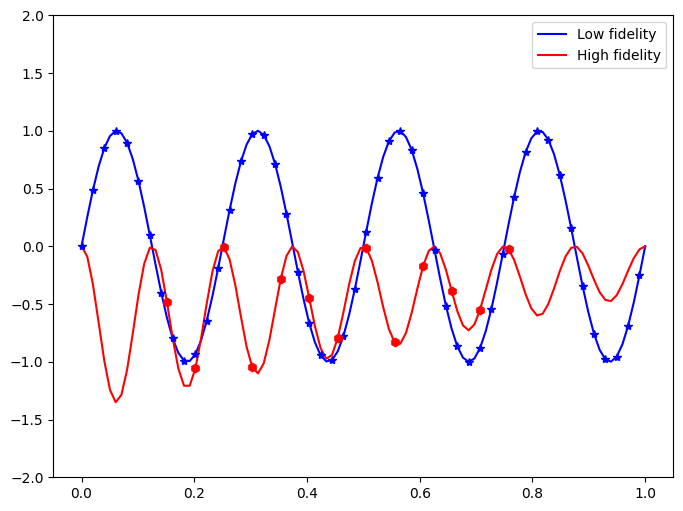

In [191]:
# Initialize plot

f, ax = plt.subplots(1, 1, figsize=(8, 6))


ax.plot(x_low.numpy(), y_low.numpy(), '-', color = "blue")
ax.plot(x_high.numpy(), y_high.numpy(), '-', color = "red")
ax.plot(x_train_low.numpy(), y_train_low.numpy(), '*', color = "blue")
ax.plot(x_train_high.numpy(), y_train_high.numpy(), 'h', color = "red")
ax.set_ylim([-2, 2])
ax.legend(['Low fidelity', 'High fidelity'])
plt.show()



## **Custom Linear Kernel**

We will consider a custom linear kernel to allow going through the origin at arbitrary locations. In the default implementation of gpytorch the linear kernel enforces that all lines go through the origin, which may be a little restrictive.

In [192]:
class CustomLinKernel(gpytorch.kernels.LinearKernel):

    def __init__(self, num_active_dimensions: Optional[int] = None, num_dimensions: Optional[int] = None,
        offset_prior: Optional[Prior] = None, variance_prior: Optional[Prior] = None,
        variance_constraint: Optional[Interval] = None, **kwargs,
    ):

        super(CustomLinKernel, self).__init__(num_dimensions, offset_prior, variance_prior, variance_constraint, **kwargs)

        if num_active_dimensions is not None:
            self.num_active_dimensions = num_active_dimensions
            self.register_parameter(name="c", parameter=torch.nn.Parameter(torch.zeros(1, self.num_active_dimensions)))

    def forward(self, x1, x2, **params):

        # We center the data before calling to the linear kernel

        return super(CustomLinKernel, self).forward(x1 - self.c , x2 - self.c, **params) 


## **Defining Multifidelity Deep GP layers**

In GPyTorch, defining a GP involves extending one of our abstract GP models and defining a forward method that returns the prior. For deep GPs, things are similar, but there are two abstract GP models that must be overwritten: one for hidden layers and one for the deep GP model itself.

In the next cell, we define an example of a Multifidelity deep GP hidden layer. This looks very similar to every other variational GP you might define. However, there are a few key differences:

*   Instead of extending ApproximateGP, we extend DeepGPLayer.


Multifidelity DeepGPLayers also have different inputs depending on whether or not they are the first layer. For simplicity, we will consider a simple architecture with only two possible fidelity levels.


In [193]:
class MFDeepGPHiddenLayer(DeepGPLayer):
    def __init__(self, first_layer, input_dims, num_inducing):

        output_dims = None # Each layer has a single output

        # We choose at random the inducing points
        
        inducing_points = torch.rand(num_inducing, input_dims)
        batch_shape = torch.Size([])

        # We use whitening since it improves training

        variational_distribution = CholeskyVariationalDistribution(num_inducing_points=num_inducing, batch_shape=batch_shape)
        variational_strategy = VariationalStrategy(self, inducing_points, variational_distribution, learn_inducing_locations=True)

        # We initialize the variational distribution to have a small variance

        init_dist = MultivariateNormal(torch.zeros(num_inducing), torch.eye(num_inducing) * 1e-8)
        variational_distribution.initialize_variational_distribution(init_dist)
        variational_strategy.variational_params_initialized = torch.tensor(1) # This avoids random initialization

        super(MFDeepGPHiddenLayer, self).__init__(variational_strategy, input_dims, output_dims)

        # The mean function is zero.

        self.mean_module = ZeroMean(batch_shape=batch_shape)

        # In the first layer, we use a standard RBF covariance function
        
        if first_layer == True:
            self.covar_module = ScaleKernel(RBFKernel(batch_shape=batch_shape, ard_num_dims=input_dims), \
                batch_shape=batch_shape)
        else:

            # We use the MF covariance function in layers above
            # We use the fact that the output dim of a layer is always 1 in this model

            D_range = list(range(input_dims))

            k_x_1 = ScaleKernel(RBFKernel(batch_shape=batch_shape, ard_num_dims=input_dims - 1,  \
                active_dims=D_range[ 0 : (input_dims - 1) ]), batch_shape=batch_shape)

            k_f = ScaleKernel(RBFKernel(batch_shape=batch_shape, ard_num_dims=1, \
                active_dims=D_range[ (input_dims - 1) : input_dims ]), batch_shape=batch_shape)

            k_x_2 = ScaleKernel(RBFKernel(batch_shape=batch_shape, ard_num_dims=input_dims - 1,  \
                active_dims=D_range[ 0 : (input_dims - 1) ]), batch_shape=batch_shape)

            k_lin = CustomLinKernel(num_active_dimensions = 1, batch_shape=batch_shape, active_dims=D_range[ (input_dims - 1) : input_dims ])

            self.covar_module = k_x_1 * (k_lin + k_f) + k_x_2

    def forward(self, x):

        mean_x = self.mean_module(x)

        covar_x = self.covar_module(x)

        return MultivariateNormal(mean_x, covar_x)



## **Building the Multifidelity deep GP**

Now that we’ve defined a class for our hidden layers, we can build our Multifidelity deep GP. To do this, we create a Module whose forward is simply responsible for forwarding through the various layers. 


In [194]:
# We create the deep GP

class MFDSVIDeepGP(DeepGP):
    def __init__(self, input_dims, num_inducing):

        # We create the two layers in this model. 
        # The second layer will receive inputs and also output from the first layer.
        
        first_layer = MFDeepGPHiddenLayer(True, input_dims, num_inducing)
        second_layer = MFDeepGPHiddenLayer(False, input_dims + 1, num_inducing)

        super().__init__()

        self.first_layer = first_layer
        self.second_layer = second_layer
        self.likelihood_first_layer = GaussianLikelihood()
        self.likelihood_second_layer = GaussianLikelihood()

        # We consider small noise initially
        
        self.likelihood_first_layer.noise = 0.0001
        self.likelihood_second_layer.noise = 0.0001

    def forward(self, inputs):

        # The forward method lets the data go through each layer by
        # sampling from the predictive distribution of each layer.
        # Note that the second layer will receive inputs and also first layer
        # output.

        first_layer_output = self.first_layer(inputs)
        hidden_values = torch.cat([ inputs ] + [ first_layer_output.rsample().T ], dim=-1)
        second_layer_output = self.second_layer(hidden_values)

        # We return a list with the output of each layer, which
        # is a multivariate gaussian

        return [ first_layer_output, second_layer_output ]

    def predict(self, test_data, num_samples = 100):

        # We compute predictions for the test data for the whole model

        with torch.no_grad():
            means_low = torch.zeros(test_data.shape[ 0 ], num_samples)
            variances_low = torch.zeros(test_data.shape[ 0 ], num_samples)
            means_high = torch.zeros(test_data.shape[ 0 ], num_samples)
            variances_high = torch.zeros(test_data.shape[ 0 ], num_samples)

            for i in range(num_samples):

                with gpytorch.settings.num_likelihood_samples(1):
                    output = self(test_data)
                    preds = self.likelihood_first_layer(output[ 0 ])
                    means_low[ :, i ] = preds.mean
                    variances_low[ :, i ] = preds.variance

                    preds = self.likelihood_second_layer(output[ 1 ])
                    means_high[ :, i ] = preds.mean
                    variances_high[ :, i ] = preds.variance

        return means_low, variances_low, means_high, variances_high

    # MFDGPs are difficult to train and require a two-step process. In
    #  the first step, the noise of each layer and the covariance matrix 
    # of each q distribution are fixed. In the second step covariance
    # function parameters are fixed.
    
    def fix_noise_and_varitional_covs(self, value):
        
            self.likelihood_first_layer.raw_noise.requires_grad = not value
            self.likelihood_second_layer.raw_noise.requires_grad = not value

            self.first_layer.variational_strategy._variational_distribution.chol_variational_covar.requires_grad = not value
            self.second_layer.variational_strategy._variational_distribution.chol_variational_covar.requires_grad = not value

            # We use learned covariance

            if value is False:
                for par in self.first_layer.covar_module.parameters():
                    par.requires_grad = False
                for par in self.second_layer.covar_module.parameters():
                    par.requires_grad = False


After this, we are ready to create our MF DGP using the training data.

In [195]:
num_inducing_points = 100
model = MFDSVIDeepGP(x_train_low.shape[ -1 ], num_inducing_points)

Now, we are ready to train the model. The loss is the specific loss for MF DGPs that will consider the DSVI objective. This loss is already implemented in gpytorch but requires slight modifications to account for multi-fidelity data and the MF DGP architecture.

In [196]:
# Evaluates ELBO of the Multi-fidelity DGP

class VariationalELBOMF(VariationalELBO):

    def __init__(self, model, num_data):

        super().__init__(None, model, num_data)
        
    # The forward method should receive the predictive distribution for the point, the target, and the corresponding fidelity

    def forward(self, l_approximate_dist_f, targets, fidelities):

        data_term = (self.model.likelihood_first_layer.expected_log_prob(targets.T, l_approximate_dist_f[ 0 ])[ fidelities.T == 0 ]).sum()
        data_term += (self.model.likelihood_second_layer.expected_log_prob(targets.T, l_approximate_dist_f[ 1 ])[ fidelities.T == 1 ]).sum()

        kl_divergence = self.model.variational_strategy.kl_divergence()

        return data_term - kl_divergence


We are ready to train the model. For that, we will use ADAM.

In [197]:
from torch.utils.data import TensorDataset, DataLoader

def train_mfdgp_dsvi(model, x_train, y_train, fidelities, num_epochs, lr = 1e-3, num_samples = 1):

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    mll = VariationalELBOMF(model, x_train.shape[-2])

    for training_iter in range(num_epochs):

    # Within each iteration, we will go over each minibatch of data

        # We iterate over the batches

        with gpytorch.settings.num_likelihood_samples(num_samples):
            optimizer.zero_grad()
            output = model(x_train)
            loss = -mll(output, y_train, fidelities)
            loss.backward()
            optimizer.step()

        print('Iteration %d/%d - Loss: %f' % (training_iter + 1, num_epochs, loss.item()))


We concatenate the data from each fidelity

In [198]:
x_train = torch.cat([ x_train_low ] + [ x_train_high ], axis = 0)
y_train = torch.cat([ y_train_low ] + [ y_train_high ], axis = 0)
fidelities = torch.cat([ torch.zeros( x_train_low.shape[ 0 ], 1) ] + [ torch.ones(x_train_high.shape[ 0 ], 1) ], axis = 0)


Now, we train the model. First, we fit the model freezing parameters, then without freezing. This is a limitation of MF DGPs, which require careful training to guarantee that the covariance hyper-parameters are learnt properly.


In [199]:
model.fix_noise_and_varitional_covs(True)
train_mfdgp_dsvi(model, x_train, y_train, fidelities, 15000, lr = 1e-3)
model.fix_noise_and_varitional_covs(False)
train_mfdgp_dsvi(model, x_train, y_train, fidelities, 15000, lr = 1e-3)

Iteration 1/15000 - Loss: 147955.702701
Iteration 2/15000 - Loss: 147790.890644
Iteration 3/15000 - Loss: 147627.994673
Iteration 4/15000 - Loss: 147466.047206
Iteration 5/15000 - Loss: 147302.483941
Iteration 6/15000 - Loss: 147137.742784
Iteration 7/15000 - Loss: 146972.620992
Iteration 8/15000 - Loss: 146807.807912
Iteration 9/15000 - Loss: 146640.431239
Iteration 10/15000 - Loss: 146474.998183
Iteration 11/15000 - Loss: 146308.838112
Iteration 12/15000 - Loss: 146143.180239
Iteration 13/15000 - Loss: 145974.331190
Iteration 14/15000 - Loss: 145805.075681
Iteration 15/15000 - Loss: 145639.892947
Iteration 16/15000 - Loss: 145469.349530
Iteration 17/15000 - Loss: 145300.709868
Iteration 18/15000 - Loss: 145131.633590
Iteration 19/15000 - Loss: 144962.853401
Iteration 20/15000 - Loss: 144796.209993
Iteration 21/15000 - Loss: 144626.293255
Iteration 22/15000 - Loss: 144458.669793
Iteration 23/15000 - Loss: 144286.570020
Iteration 24/15000 - Loss: 144119.385552
Iteration 25/15000 - Loss

After training, we can compute predictions on test data.

In [200]:
x_test = torch.linspace(0,1,200).reshape((200, 1))
means_low, variances_low, means_high, variances_high = model.predict(x_test, num_samples = 1000)

mean_low = torch.mean(means_low, -1)
var_low = torch.mean(means_low**2 + variances_low, -1) - mean_low**2

mean_high = torch.mean(means_high, -1)
var_high = torch.mean(means_high**2 + variances_high, -1) - mean_high**2


We plot the predictive distribution.

/tmp/ipykernel_96655/2516971889.py:21: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()


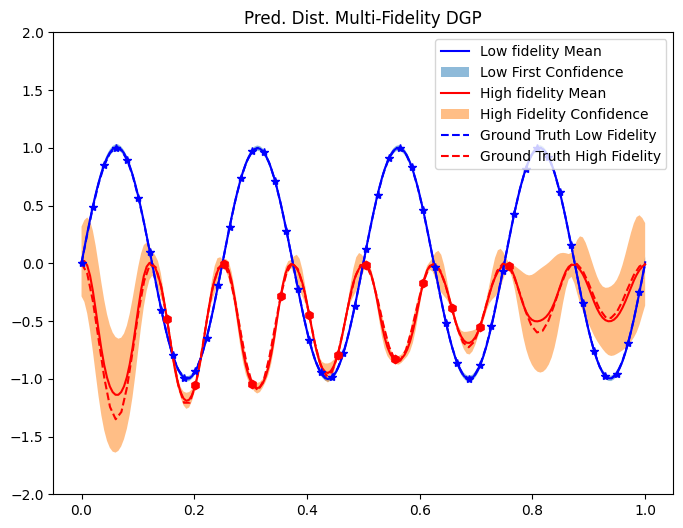

In [201]:
def plot_predictive_dgp(mean_low, var_low, mean_high, var_high, title):
    f, ax = plt.subplots(1, 1, figsize=(8, 6))
    lower_low = mean_low + 2.0 * np.sqrt(var_low)
    upper_low = mean_low - 2.0 * np.sqrt(var_low)
    ax.plot(x_test, mean_low, 'b')
    ax.fill_between(x_test[ :, 0 ], lower_low, upper_low, alpha=0.5)

    lower_high = mean_high + 2.0 * np.sqrt(var_high)
    upper_high = mean_high - 2.0 * np.sqrt(var_high)
    ax.plot(x_test, mean_high, 'r')
    ax.fill_between(x_test[ :, 0 ], lower_high, upper_high, alpha=0.5)

    ax.plot(x_low.numpy(), y_low.numpy(), '--', color = "blue")
    ax.plot(x_high.numpy(), y_high.numpy(), '--', color = "red")
    ax.plot(x_train_low.numpy(), y_train_low.numpy(), '*', color = "blue")
    ax.plot(x_train_high.numpy(), y_train_high.numpy(), 'h', color = "red")
    ax.set_ylim([-2, 2])
    ax.legend(['Low fidelity Mean', "Low First Confidence", 'High fidelity Mean', \
               "High Fidelity Confidence", "Ground Truth Low Fidelity", "Ground Truth High Fidelity"])
    ax.set_title(title)
    f.show()

plot_predictive_dgp(mean_low, var_low, mean_high, var_high, "Pred. Dist. Multi-Fidelity DGP")


# **Comparison with a standard GP**
We also train a standard GP on each fidelity and plot the resulting predictive distribution.

In [202]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):

        # We call the superclass with the training data and the associated likelihood.

        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)

        # We consdier a constant mean equal to zero, which the typical case.

        self.mean_module = gpytorch.means.ZeroMean()

        # We consider a squared exponential (RBF) kernel with an amplitude (scale) parameter.

        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

        # We set the initial value for the length-scale parameter

    def forward(self, x):

        # The forwward method simply computes the prior means and covariances of the
        # process values associated to the input data.

        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)

        # We return a multivariate Gaussian distribution with teh corresponding mean
        # and covariances.

        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)



We create the model again with the new prior mean and covariance function. First, for the lower fidelity data.


In [203]:
likelihood_gp_low = gpytorch.likelihoods.GaussianLikelihood()
likelihood_gp_low.noise = 0.001
model_gp_low = ExactGPModel(x_train_low, y_train_low[ :, 0 ], likelihood_gp_low)


We now train the standard GP on the low fidelity data.

In [204]:
# Use instantiate the ADAM optimizer, which will optimize all model's parameters
# including the likelihood paramters, i.e., the noise variance.

optimizer = torch.optim.Adam(model_gp_low.parameters(), lr=0.1)

# "Loss" for GPs - the marginal log likelihood

def train_gp(model, train_x, train_y):

    model.train()

    training_iter = 200

    for i in range(training_iter):

        # Zero gradients from previous iteration

        optimizer.zero_grad()

        # Compute model predictions prior predictions.

        output = model(train_x)

        # Calc loss and backprop gradients.

        loss = -mll(output, train_y)
        loss.backward()

        print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
            i + 1, training_iter, loss.item(),
            model.covar_module.base_kernel.lengthscale.item(),
            model.likelihood.noise.item()
        ))

        optimizer.step()

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood_gp_low, model_gp_low)
train_gp(model_gp_low, x_train_low, y_train_low[ :, 0 ])

Iter 1/200 - Loss: 222.363   lengthscale: 0.693   noise: 0.001
Iter 2/200 - Loss: 202.791   lengthscale: 0.644   noise: 0.001
Iter 3/200 - Loss: 184.876   lengthscale: 0.600   noise: 0.001
Iter 4/200 - Loss: 168.465   lengthscale: 0.558   noise: 0.001
Iter 5/200 - Loss: 153.396   lengthscale: 0.518   noise: 0.001
Iter 6/200 - Loss: 139.506   lengthscale: 0.480   noise: 0.002
Iter 7/200 - Loss: 126.694   lengthscale: 0.444   noise: 0.002
Iter 8/200 - Loss: 114.935   lengthscale: 0.411   noise: 0.002
Iter 9/200 - Loss: 104.248   lengthscale: 0.380   noise: 0.002
Iter 10/200 - Loss: 94.640   lengthscale: 0.350   noise: 0.002
Iter 11/200 - Loss: 86.076   lengthscale: 0.321   noise: 0.002
Iter 12/200 - Loss: 78.491   lengthscale: 0.295   noise: 0.003
Iter 13/200 - Loss: 71.753   lengthscale: 0.270   noise: 0.003
Iter 14/200 - Loss: 65.414   lengthscale: 0.248   noise: 0.003
Iter 15/200 - Loss: 58.255   lengthscale: 0.227   noise: 0.003
Iter 16/200 - Loss: 49.068   lengthscale: 0.209   noise

We compute the predictive distribution.

In [205]:
model_gp_low.eval()

with torch.no_grad():
    pred = likelihood_gp_low(model_gp_low(x_test))
    mean_low_gp = pred.mean
    var_low_gp = pred.variance


We repeat and train the model on the high fidelity data. 

In [206]:
likelihood_gp_high = gpytorch.likelihoods.GaussianLikelihood()
likelihood_gp_high.noise = 0.001
model_gp_high = ExactGPModel(x_train_high, y_train_high[ :, 0 ], likelihood_gp_high)

# Use instantiate the ADAM optimizer, which will optimize all model's parameters
# including the likelihood paramters, i.e., the noise variance.

optimizer = torch.optim.Adam(model_gp_high.parameters(), lr=0.1)

# "Loss" for GPs - the marginal log likelihood

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood_gp_high, model_gp_high)

train_gp(model_gp_high, x_train_high, y_train_high[ :, 0 ])


Iter 1/200 - Loss: 55.482   lengthscale: 0.693   noise: 0.001
Iter 2/200 - Loss: 50.562   lengthscale: 0.644   noise: 0.001
Iter 3/200 - Loss: 46.042   lengthscale: 0.598   noise: 0.001
Iter 4/200 - Loss: 41.906   lengthscale: 0.555   noise: 0.001
Iter 5/200 - Loss: 38.134   lengthscale: 0.513   noise: 0.001
Iter 6/200 - Loss: 34.703   lengthscale: 0.474   noise: 0.002
Iter 7/200 - Loss: 31.588   lengthscale: 0.437   noise: 0.002
Iter 8/200 - Loss: 28.766   lengthscale: 0.402   noise: 0.002
Iter 9/200 - Loss: 26.214   lengthscale: 0.369   noise: 0.002
Iter 10/200 - Loss: 23.913   lengthscale: 0.338   noise: 0.002
Iter 11/200 - Loss: 21.848   lengthscale: 0.310   noise: 0.002
Iter 12/200 - Loss: 20.002   lengthscale: 0.283   noise: 0.003
Iter 13/200 - Loss: 18.354   lengthscale: 0.261   noise: 0.003
Iter 14/200 - Loss: 16.878   lengthscale: 0.243   noise: 0.003
Iter 15/200 - Loss: 15.550   lengthscale: 0.230   noise: 0.003
Iter 16/200 - Loss: 14.352   lengthscale: 0.221   noise: 0.004
I

We compute the predictions for the high fidelity function.

In [207]:
model_gp_high.eval()

with torch.no_grad():
    pred = likelihood_gp_high(model_gp_high(x_test))
    mean_high_gp = pred.mean
    var_high_gp = pred.variance


We plot the standard GP predictive distribution.

/tmp/ipykernel_96655/2516971889.py:21: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()


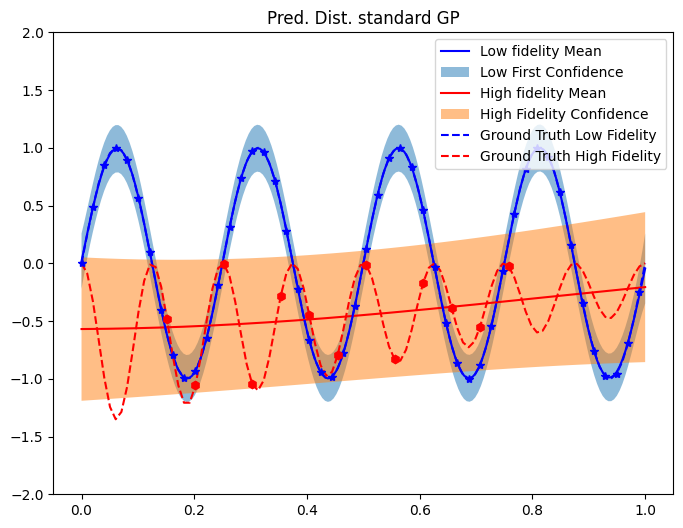

In [208]:
plot_predictive_dgp(mean_low_gp, var_low_gp, mean_high_gp, var_high_gp, "Pred. Dist. standard GP")



We observe that the predictive distribution for the low fidelity data seems apropiate. However, for the high fidelity data, which has less observed data, the model interprets that most of the variance is due to observational noise. It fails to capture the patterns in the data.

# **Task 1**

Try changing the synthetic function and repeating the experiments using as low and high fidelity latent functions, respectively:

$$ y_{low}(x) = cos(15x)$$

$$ y_{high}(x) = x · exp(y_{low}(2x - 0.2) -1$$ 

You can use the same input locations.